# MNIST

Learn to recognize handwritten digits.

1. Load MNIST data from OpenML
2. Normalize the data

In [1]:
## Installation
## !pip install matplotlib
## !pip install torch scikit-learn 
## !pip install pandas

## 1 Load MNIST data from OpenML

fetch_openml is a scikit-learn function used to download datasets from the OpenML repository, a public platform for machine learning data. https://www.openml.org

It can identify datasets by their name and version or by their unique integer data_id. The function returns a Bunch object, similar to a dictionary, containing the dataset's data, target, and description, which can then be used for machine learning tasks.

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X_raw, y_raw = mnist['data'], mnist['target']

In [3]:
print("data   is of type", type(X_raw), "with shape", X_raw.shape)
print("target is of type", type(y_raw), "with shape", y_raw.shape)

data   is of type <class 'numpy.ndarray'> with shape (70000, 784)
target is of type <class 'numpy.ndarray'> with shape (70000,)


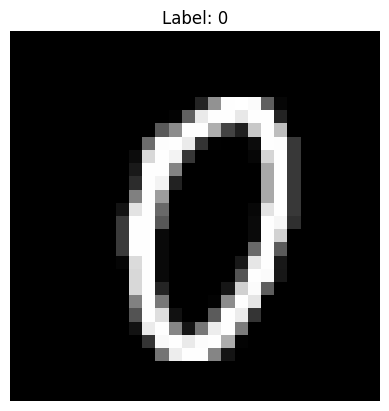

In [4]:
# Show image
X = X_raw.reshape(-1, 28, 28)  # reshape to images
y = y_raw.astype(int)
plt.imshow(X[1000], cmap='gray')
plt.title(f"Label: {y[1000]}")
plt.axis('off')
plt.show()

## 2. Normalize the Data and Target

In [5]:
import numpy as np
# Precision
X = X_raw.astype(np.float32)
y = y_raw.astype(int)
print(X.dtype, y.dtype)

# Values between 0 and 1
X = X/255.0

# Normalize with mean and standard deviation
mean = X.mean()
std = X.std()
print(mean, std)

X = (X - mean) / std

float32 int64
0.13092536 0.30844852


## 3. Split Data in Train, Validation and Test

Use Pytorch dataset for split in train, validation and test set and dataloader for batching

In [6]:
import torch 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# DataSet
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = MyDataset(X, y)
print(f"There are {len(dataset)} samples in dataset.")
#print(dataset[0])  # Erstes Sample (Feature-Vektor, Label)

# Sizes
n_total = len(dataset)
n_train = int(0.7 * n_total)  # 70% train
n_val   = int(0.2 * n_total)  # 20% validation
n_test  = n_total - n_train - n_val  # remaining 10%

# Split
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

print(f"There are {len(train_set)} samples in train dataset.")
print(f"There are {len(val_set)} samples in validation dataset.")
print(f"There are {len(test_set)} samples in test dataset.")

There are 70000 samples in dataset.
There are 49000 samples in train dataset.
There are 14000 samples in validation dataset.
There are 7000 samples in test dataset.


In [7]:
# Hyperparameter
batch_size = 64
learning_rate = 0.0001
epochs = 10

In [8]:
# Use DataLoader für Mini-Batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) #<-- no shuffle here!

## Multi-Layer Perceptron for Classification 

![Multi-Layer Perceptron](MLP.png)

In [9]:
from torch import nn

class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),  # Eingabe: 784 -> 128
            nn.ReLU(),
            nn.Linear(256, 128),    # Zwischenschicht: 128 -> 64
            nn.ReLU(),
            nn.Linear(128, 64),     # Zwischenschicht: 128 -> 64
            nn.ReLU(),
            nn.Linear(64, 10),      # Ausgabe: 64 -> 10 Klassen
        ) 

    def forward(self, x):
        x = self.flatten(x) # Bild (1x28x28) zu Vektor, if input is of shape (batch,28,28)
        logits = self.linear_relu_stack(x) # Keine Softmax nötig -> CrossEntropyLoss übernimmt das in PyTorch
        return logits

## Detect device and generate model

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

model = MNIST().to(device)
model

mps


MNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Loss Function and Optimizer

In [11]:
print(sum(p.numel() for p in model.parameters()))

242762


In [12]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## Train the model

In [13]:
from datetime import datetime

for epoch in range(1, epochs+1):
    model.train() # enable training mode (dropout, batchnorm)
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    #save the parameters of model after each epoch
    t = datetime.now().replace(microsecond=0).isoformat().replace(":","-")
    model_filename = f"models/mnist_{epoch}_{t}_model_weights.pth"
    torch.save(model.state_dict(), model_filename)
    
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}% Saved {model_filename}")



Epoch 1, Loss: 0.6456, Validation Accuracy: 91.86% Saved models/mnist_1_2025-10-19T09-33-34_model_weights.pth
Epoch 2, Loss: 0.2598, Validation Accuracy: 93.60% Saved models/mnist_2_2025-10-19T09-33-38_model_weights.pth
Epoch 3, Loss: 0.2034, Validation Accuracy: 94.66% Saved models/mnist_3_2025-10-19T09-33-43_model_weights.pth
Epoch 4, Loss: 0.1655, Validation Accuracy: 95.60% Saved models/mnist_4_2025-10-19T09-33-48_model_weights.pth
Epoch 5, Loss: 0.1398, Validation Accuracy: 95.95% Saved models/mnist_5_2025-10-19T09-33-53_model_weights.pth
Epoch 6, Loss: 0.1188, Validation Accuracy: 96.50% Saved models/mnist_6_2025-10-19T09-33-58_model_weights.pth
Epoch 7, Loss: 0.1027, Validation Accuracy: 96.76% Saved models/mnist_7_2025-10-19T09-34-03_model_weights.pth
Epoch 8, Loss: 0.0893, Validation Accuracy: 97.07% Saved models/mnist_8_2025-10-19T09-34-08_model_weights.pth
Epoch 9, Loss: 0.0780, Validation Accuracy: 97.05% Saved models/mnist_9_2025-10-19T09-34-13_model_weights.pth
Epoch 10, 

In [15]:
# Use Test Set for Final Check
model = MNIST()  # initialize the same model!!

# Load the stored parameters with best validation loss
model_filename = "models/mnist_10_2025-10-19T09-34-18_model_weights.pth"
model.load_state_dict(torch.load(model_filename))

model.to(device)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) # batch-size x 10
        values, indices = torch.max(outputs, 1) #first max value, second max index --> the number we want to predict
        correct += (indices == labels).sum().item() # Anzahl richtiger Paar-Vergleiche 
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.10%
